In [ ]:
# Installazione librerie principali per data science / machine learning
# - pandas: gestione dati tabellari (DataFrame)
# - scikit-learn: algoritmi ML classici, preprocessing, validazione, metriche
# - joblib: salvataggio e caricamento efficiente di modelli (usato da sklearn)
# - xgboost: una delle implementazioni più veloci e performanti di gradient boosting
!pip install -q pandas scikit-learn joblib xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib


In [ ]:
from google.colab import files

# Carica kaggle.json (da Kaggle → Account → Create New Token)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matteocasti","key":"4a4c744a20248945d525739019479f7d"}'}

In [ ]:
# Crea cartella ~/.kaggle (se non esiste) e sposta/proteggi kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/          # sposta il file caricato
!chmod 600 ~/.kaggle/kaggle.json    # solo il proprietario può leggerlo/scriverlo

In [ ]:
# Scarica il dataset TII-SSRC-23 (network traffic per intrusion detection, ~3 GB zipped)
# Contiene CSV con feature estratte + PCAP raw; benign + malicious (DoS, Mirai botnet, bruteforce, etc.)
!kaggle datasets download -d daniaherzalla/tii-ssrc-23

Dataset URL: https://www.kaggle.com/datasets/daniaherzalla/tii-ssrc-23
License(s): CC-BY-SA-4.0
tii-ssrc-23.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Decomprimi il file zip (~3 GB) nella cartella tii_ssrc23 (crea la dir se non esiste)
# Estrae CSV con feature estratte + PCAP raw (traffico benigno/malizioso: DoS, Mirai, bruteforce, info gathering...)
!unzip tii-ssrc-23.zip -d tii_ssrc23

Archive:  tii-ssrc-23.zip
replace tii_ssrc23/csv/data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Installa imbalanced-learn → tecniche per gestire dataset sbilanciati (oversampling, undersampling, SMOTE...)
# Molto utile per TII-SSRC-23 (traffico benigno vs multipli tipi malicious → forte imbalance comune in IDS)
!pip install -q imbalanced-learn

In [ ]:
# =========================================================
#  IMPORTS – Gathering all the tools we will need
# =========================================================

import pandas as pd                  # Core library for reading and manipulating tabular data (DataFrames)
import numpy as np                   # Fast numerical operations on arrays and matrices

import matplotlib.pyplot as plt      # Plotting library (kept here for potential future visualizations)

from sklearn.model_selection import train_test_split, StratifiedKFold
# train_test_split    → Splits data into training and testing sets while preserving class distribution
# StratifiedKFold     → Prepares for stratified cross-validation (not used yet, but ready for future improvement)

from sklearn.ensemble import RandomForestClassifier
# RandomForestClassifier → Builds an ensemble of decision trees → strong, robust baseline for tabular classification

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
# classification_report → Prints precision, recall, F1-score and support per class
# roc_auc_score       → Computes Area Under the ROC Curve → excellent metric for imbalanced binary problems
# roc_curve, auc      → Used to plot ROC curve (not plotted here, but imported for extension)

from sklearn.preprocessing import StandardScaler, LabelEncoder
# StandardScaler      → Scales features to mean=0 and std=1 (good practice, even if RF is scale-invariant)
# LabelEncoder        → Converts categorical string labels into integers (0, 1, 2…)

from imblearn.over_sampling import SMOTE
# SMOTE → Synthetic Minority Over-sampling Technique → generates synthetic examples of the minority class

import joblib                        # Efficient way to save and load large Python objects (models, scalers)
from google.colab import files       # Enables file upload/download directly in Google Colab

# =========================================================
#  CONFIGURATION
# =========================================================

csv_path = "tii_ssrc23/csv/data.csv"   # Path to the main CSV file from the TII-SSRC-23 dataset
RANDOM_STATE = 42                      # Fixed seed → ensures experiments are reproducible
N_SPLITS = 5                           # Number of folds for future cross-validation (not used yet)
CLIENT_SIZE = 0.5                      # 50% of the temporary test set will become the "client" dataset

print("Loading dataset (10% sample) and starting initial preprocessing...")

# =========================================================
#  DATA LOADING & DOWNSAMPLING
# =========================================================

try:
    df_full = pd.read_csv(csv_path)                  # Loads the entire CSV into memory as a DataFrame
    df = df_full.sample(frac=0.10, random_state=RANDOM_STATE).reset_index(drop=True)
    # .sample(frac=0.10) → randomly selects 10% of rows to keep memory usage manageable
    # reset_index(drop=True) → resets row indices to 0,1,2,… after sampling
    del df_full                                      # Immediately delete full dataset to free RAM
except FileNotFoundError:
    raise FileNotFoundError(f"ERROR: File not found at → {csv_path}")

# =========================================================
#  FEATURE CLEANING & REMOVAL
# =========================================================

# Remove columns that are useless for modeling or cause data leakage
cols_to_drop = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
                'Timestamp', 'Traffic Type', 'Traffic Subtype']

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')
# .drop(...) → safely removes listed columns if they exist

# Handle problematic values and duplicates
df = df.replace([np.inf, -np.inf], np.nan).dropna().drop_duplicates()
# .replace → converts infinite values to NaN
# .dropna()  → removes any row containing at least one NaN
# .drop_duplicates() → eliminates identical rows

# =========================================================
#  LABEL & CATEGORICAL ENCODING
# =========================================================

# Convert textual labels to binary numeric format
if df['Label'].dtype == 'object':
    df['Label'] = df['Label'].map({'Benign': 0, 'Malicious': 1})
    # .map() → applies dictionary mapping: Benign becomes 0, Malicious becomes 1

# Encode any remaining object (string) columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])
    # LabelEncoder().fit_transform() → automatically converts categories to integers

print(f"Preprocessing finished. Final shape: {df.shape}")

# =========================================================
#  TRAIN / TEST / CLIENT SPLIT
# =========================================================

X = df.drop(columns=['Label'])     # All columns except the target → features
y = df['Label']                    # Target column only

# First split: 80% train, 20% temporary (will be split again)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
# stratify=y → preserves the original class ratio in every split

# Second split: split the 20% temporary set into test + client
X_test, X_client, y_test, y_client = train_test_split(
    X_temp, y_temp, test_size=CLIENT_SIZE, stratify=y_temp, random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape} | Test: {X_test.shape} | Client: {X_client.shape}")

# =========================================================
#  MODEL PREPARATION & TRAINING
# =========================================================

scaler = StandardScaler()                    # Scaler object
smote  = SMOTE(random_state=RANDOM_STATE)    # Oversampling object
rf_model = RandomForestClassifier(
    n_estimators=200,                        # Number of trees in the forest
    random_state=RANDOM_STATE,
    n_jobs=-1                                # Use all available CPU cores
)

# Scale features (fit only on training data)
X_train_scaled = scaler.fit_transform(X_train)
# .fit_transform() → computes mean & std on train and applies transformation

X_test_scaled = scaler.transform(X_test)
# .transform() → applies the same scaling parameters (no refit!)

# Balance only the training set
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
# fit_resample → creates synthetic minority class examples to balance the dataset

# Train the model on the balanced data
rf_model.fit(X_train_res, y_train_res)
# .fit() → builds the entire random forest using the resampled data

# =========================================================
#  EVALUATION ON UNSEEN TEST SET
# =========================================================

y_pred = rf_model.predict(X_test_scaled)
# .predict() → returns the predicted class (0 or 1) for each test sample

y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]
# .predict_proba() → returns probability scores; we take column 1 (Malicious probability)

print("\nClassification Report (TEST SET):")
print(classification_report(y_test, y_pred))
# Shows detailed per-class performance + overall accuracy

print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")
# AUC-ROC → key metric for binary classification with strong class imbalance

# =========================================================
#  SAVE EVERYTHING FOR LATER USE
# =========================================================

joblib.dump(rf_model, "random_forest_model.pkl")
# Saves the trained model to disk

joblib.dump(scaler, "scaler.pkl")
# Saves the fitted scaler (needed to preprocess future data consistently)

client_data = X_client.copy()
client_data['Label'] = y_client
client_data.to_csv("client_data.csv", index=False)
# Exports the client dataset (features + labels) as CSV

print("\nSaved files:")
print(" - random_forest_model.pkl")
print(" - scaler.pkl")
print(" - client_data.csv")

# =========================================================
#  AUTOMATIC DOWNLOAD OF CLIENT DATASET
# =========================================================

print("\nDownloading client_data.csv...")
files.download("client_data.csv")
# Triggers automatic download to your local computer

📥 Caricamento dataset (10%) e Preprocessing Iniziale...
✅ Preprocessing completato. Dataset shape: (839331, 77)
📊 Train: (671464, 76), Test: (83933, 76), Client: (83934, 76)

📈 Report di classificazione (TEST SET):
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       1.00      1.00      1.00     83921

    accuracy                           1.00     83933
   macro avg       0.96      0.96      0.96     83933
weighted avg       1.00      1.00      1.00     83933

AUC: 1.0000

💾 File salvati con successo:
 - random_forest_model.pkl
 - scaler.pkl
 - client_data.csv

📤 Download del dataset client...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔄 Avvio Stratified K-Fold con ROC media...


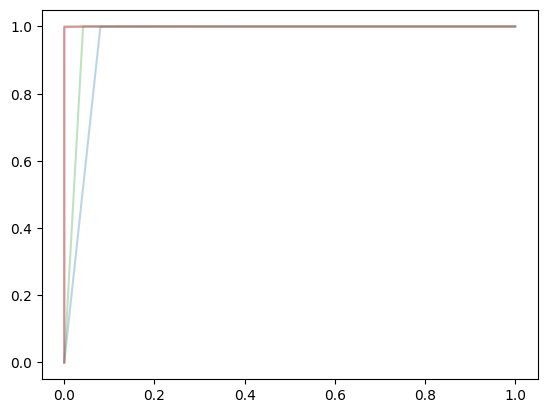

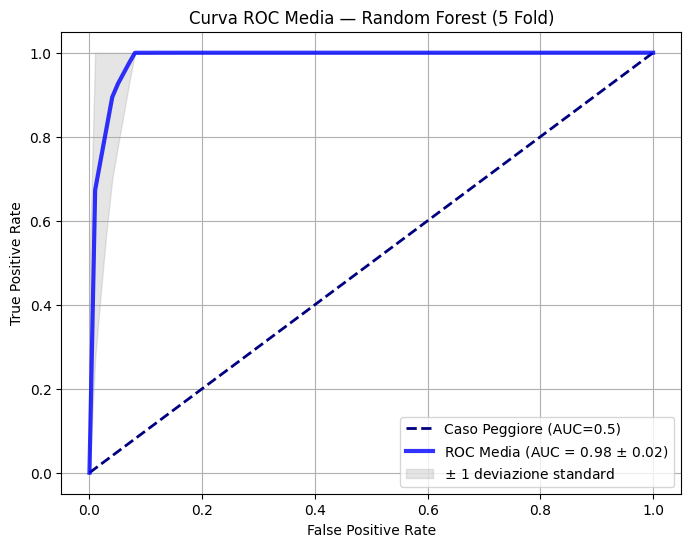


✅ AUC Media Definitiva: 0.9847 (Deviazione Standard: 0.0161)


In [ ]:
# =========================================================
#  STEP 3 — Stratified K-Fold Cross-Validation with Mean ROC Curve
# =========================================================

# We use StratifiedKFold to ensure each fold preserves the original class distribution
# (very important here because the dataset is extremely imbalanced: ~99% malicious, <<1% benign)
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Re-initialize objects inside the cross-validation loop (best practice to avoid data leakage)
scaler = StandardScaler()                    # Will be fitted independently on each training fold
smote = SMOTE(random_state=RANDOM_STATE)     # Synthetic oversampling — applied only to training folds
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1                                # Use all CPU cores for faster training
)

# Containers to collect data for the mean ROC curve
tprs = []           # List of interpolated True Positive Rates (one per fold)
auc_scores = []     # List of AUC values for each fold (to compute mean & std)
mean_fpr = np.linspace(0, 1, 100)   # Common x-axis points for interpolation (0 → 1 with 100 steps)

fold = 1
print("\nStarting Stratified {}-Fold Cross-Validation with Mean ROC computation...".format(N_SPLITS))

for train_idx, test_idx in skf.split(X, y):
    # Extract train/test splits using indices (iloc ensures we get pandas Series/DataFrames)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(f"  Fold {fold}/{N_SPLITS} — Training on {len(train_idx)} samples, testing on {len(test_idx)} samples")

    # ── Scaling ────────────────────────────────────────────────────────────────
    # Fit scaler ONLY on current training fold → prevents leakage from test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # ── SMOTE oversampling ─────────────────────────────────────────────────────
    # Apply only to training data — never touch the test fold
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # ── Train the model on balanced fold ───────────────────────────────────────
    rf_model.fit(X_train_resampled, y_train_resampled)

    # Get probability scores for the positive class (Malicious = 1)
    y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

    # ── Compute ROC curve for this fold ────────────────────────────────────────
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    # Interpolate TPR at the common FPR points (mean_fpr)
    # This allows us to average curves meaningfully across folds
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tprs.append(tpr_interp)

    # Also store individual AUC for mean & std calculation
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

    # Plot individual fold ROC (light transparency so they don't dominate)
    plt.plot(fpr, tpr, lw=1.5, alpha=0.3, label=f"Fold {fold} (AUC = {roc_auc:.3f})")

    fold += 1

# =========================================================
#  STEP 4 — Final Mean ROC Curve Plot + Confidence Band
# =========================================================

plt.figure(figsize=(9, 7))

# ── Reference line (random classifier) ──────────────────────────────────────
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random (AUC = 0.50)')

# ── Compute and plot MEAN ROC curve ─────────────────────────────────────────
mean_tpr = np.mean(tprs, axis=0)

# Force curve to start at (0,0) and end at (1,1) — numerical stability
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
std_auc  = np.std(auc_scores)

plt.plot(mean_fpr, mean_tpr, color='darkblue', lw=3, alpha=0.9,
         label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')

# ── Confidence band (±1 standard deviation) ─────────────────────────────────
std_tpr = np.std(tprs, axis=0)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1.0)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0.0)

plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='lightblue', alpha=0.15,
                 label='±1 std')

# ── Final plot cosmetics ────────────────────────────────────────────────────
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('Mean ROC Curve — Random Forest (Stratified 5-Fold CV)\nTII-SSRC-23 Dataset (10% sample)', fontsize=13)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# Print summary result
print(f"\nFinal Mean AUC across {N_SPLITS} folds: {mean_auc:.4f}")
print(f"Standard Deviation of AUC: {std_auc:.4f}")
print("Higher AUC + low std → more stable and reliable model performance.")

In [ ]:
# =========================================================
#  Extract and save the full list of features/columns from the dataset
# =========================================================

# Load ONLY the first row of the large CSV file
# → nrows=1 is very efficient: we don't need to read millions of rows just to get column names
df = pd.read_csv("tii_ssrc23/csv/data.csv", nrows=1)

# Create (or overwrite) a clean text file containing one feature name per line
with open("master_feature_list_86.txt", "w") as f:
    for column_name in df.columns:
        f.write(column_name + "\n")
        # Each column name is written on its own line → easy to read, copy-paste or use as reference

# Confirmation message
print("File 'master_feature_list_86.txt' generated successfully.")
print(f"Total features extracted: {len(df.columns)}")

In [ ]:
import os
import shutil
import zipfile
import random

# =========================================================
#  CONFIGURATION — Paths and output folder setup
# =========================================================

# Base directory containing the original PCAP files organized by class/subtype
# (from the TII-SSRC-23 dataset — huge raw packet captures)
BASE = "tii_ssrc23/pcap"

# Destination folder where we will collect a small, curated test set of PCAPs
OUTPUT = "pcap_test_set"

# Clean previous runs (if any) and recreate the output directory
# → ensures we always start from a clean state
if os.path.exists(OUTPUT):
    shutil.rmtree(OUTPUT)               # Recursively delete the folder and all contents
os.makedirs(OUTPUT, exist_ok=True)      # Create the folder (exist_ok avoids error if already exists)

# =========================================================
#  HELPER FUNCTION — Pick and copy one random PCAP per category
# =========================================================

def pick_random_pcap(source_dir, output_dir, label):
    """
    Selects ONE random .pcap file from the given source directory
    and copies it to the output folder with a descriptive prefix (e.g. benign_audio_xxx.pcap)

    Args:
        source_dir (str): Path to the subcategory folder (e.g. tii_ssrc23/pcap/benign/audio)
        output_dir (str): Where to save the selected file
        label (str): Prefix to add to the filename (helps identify class/subtype later)
    """
    if not os.path.exists(source_dir):
        print(f"  Directory not found: {source_dir}")
        return

    # Collect only files ending with .pcap
    files = [f for f in os.listdir(source_dir) if f.lower().endswith(".pcap")]

    if not files:
        print(f"  No PCAP files found in {source_dir}")
        return

    # Randomly choose one file (random.choice is perfect for uniform sampling)
    chosen_file = random.choice(files)

    src_path = os.path.join(source_dir, chosen_file)
    dst_path = os.path.join(output_dir, f"{label}_{chosen_file}")

    # Copy the file (shutil.copy preserves metadata and is efficient)
    shutil.copy(src_path, dst_path)

    print(f"  Selected random PCAP → {dst_path}")

# =========================================================
#  STEP 1 — Collect one random benign PCAP from each subtype
# =========================================================

print("Collecting random BENIGN PCAPs...")

pick_random_pcap(f"{BASE}/benign/audio",      OUTPUT, "benign_audio")
pick_random_pcap(f"{BASE}/benign/background", OUTPUT, "benign_background")
pick_random_pcap(f"{BASE}/benign/text",       OUTPUT, "benign_text")
pick_random_pcap(f"{BASE}/benign/video",      OUTPUT, "benign_video")

# =========================================================
#  STEP 2 — Collect one random malicious PCAP from key attack types
# =========================================================

print("\nCollecting random MALICIOUS PCAPs...")

pick_random_pcap(f"{BASE}/malicious/bruteforce",          OUTPUT, "mal_bruteforce")
pick_random_pcap(f"{BASE}/malicious/dos",                 OUTPUT, "mal_dos")
pick_random_pcap(f"{BASE}/malicious/information-gathering", OUTPUT, "mal_infogathering")
pick_random_pcap(f"{BASE}/malicious/mirai-botnet",        OUTPUT, "mal_mirai")

# =========================================================
#  STEP 3 — Package everything into a single ZIP archive
# =========================================================

print("\nCreating ZIP archive...")

zip_path = "pcap_test_set.zip"

# 'w' = write mode, ZIP_DEFLATED = standard compression (good balance size/speed)
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Loop through every file in the output folder
    for filename in os.listdir(OUTPUT):
        full_path = os.path.join(OUTPUT, filename)
        # Write file into ZIP with its original name (no subfolders inside ZIP)
        zipf.write(full_path, arcname=filename)

print(f"ZIP file created successfully: {zip_path}")
print(f"Contains {len(os.listdir(OUTPUT))} PCAP files ready for analysis / sharing.")